In [1]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
from nets  import nets_factory
import matplotlib.pyplot as plt

D:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#字符数量
CHAR_NUM=10
#图片高度
IMAGE_HEIGHT=60
IMAGE_WIDTH=160
BATCH_SIZE=1
TFRECORD_FILE="D:/Tensorflow/captcha/test.tfrecords"

x=tf.placeholder(tf.float32,[None,224,224])

print('1')
def  read_and_decode(filename):
    #根据文件名生成队列
    filename_queue=tf.train.string_input_producer([filename])
    reader=tf.TFRecordReader()
    #返回文件名和文件
    _, serialized_example=reader.read(filename_queue)
    features=tf.parse_single_example(serialized_example,features={'image':tf.FixedLenFeature([],tf.string),
                                                                  'label0':tf.FixedLenFeature([],tf.int64),
                                                                  'label1':tf.FixedLenFeature([],tf.int64),
                                                                  'label2':tf.FixedLenFeature([],tf.int64),
                                                                  'label3':tf.FixedLenFeature([],tf.int64)
                                                                 })
    image=tf.decode_raw(features['image'],tf.uint8)
    image_raw=tf.reshape(image,[224,224]) #保留原图以便显示使用
    image=tf.reshape(image,[224,224])
    image=tf.cast(image,tf.float32)/255.0 #把原图像素值由0-255变为-1 - 1
    image=tf.subtract(image,0.5)
    image=tf.multiply(image,2.0)
    
    label0=tf.cast(features['label0'],tf.int32)
    label1=tf.cast(features['label1'],tf.int32)
    label2=tf.cast(features['label2'],tf.int32)
    label3=tf.cast(features['label3'],tf.int32)
    return image,image_raw,label0,label1,label2,label3


1


INFO:tensorflow:Restoring parameters from ./captcha/models/crack_captcha.model-1


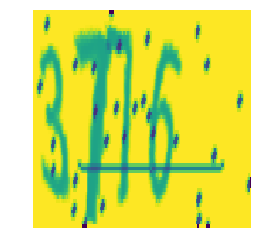

label: [3] [1] [7] [6]
predict: [3] [1] [7] [6]


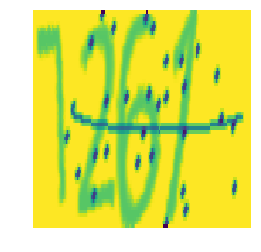

label: [7] [2] [6] [1]
predict: [7] [2] [6] [1]


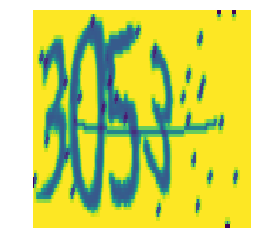

label: [3] [0] [5] [3]
predict: [3] [0] [5] [3]


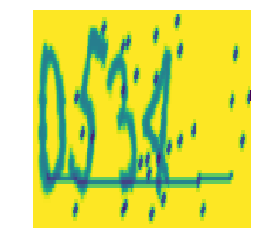

label: [0] [5] [3] [4]
predict: [0] [5] [1] [4]


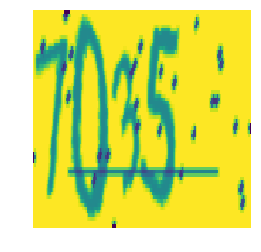

label: [7] [0] [3] [5]
predict: [7] [0] [3] [5]


In [3]:
image,image_raw,label0,label1,label2,label3=read_and_decode(TFRECORD_FILE)
#print(len(sess.run(image)))
image_batch,image_raw_batch,label_batch0,label_batch1,label_batch2,label_batch3=tf.train.shuffle_batch(
    [image,image_raw,label0,label1,label2,label3],batch_size=BATCH_SIZE,capacity=53,min_after_dequeue=50,num_threads=1)
train_network_fn=nets_factory.get_network_fn(
  'alexnet_v2',
  num_classes=CHAR_NUM,
  weight_decay=0.0005,
  is_training=False)
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(log_device_placement=False,allow_soft_placement=True,gpu_options=gpu_options)) as sess:

    X=tf.reshape(x,[BATCH_SIZE,224,224,1])      
    logits0,logits1,logits2,logits3,end_pintos=train_network_fn(X)
    prediction0=tf.reshape(logits0,[-1,CHAR_NUM])
    prediction0=tf.argmax(prediction0,1)
    
    prediction1=tf.reshape(logits1,[-1,CHAR_NUM])
    prediction1=tf.argmax(prediction1,1)
    
    prediction2=tf.reshape(logits2,[-1,CHAR_NUM])
    prediction2=tf.argmax(prediction2,1)
    
    prediction3=tf.reshape(logits3,[-1,CHAR_NUM])
    prediction3=tf.argmax(prediction3,1)

    
    saver=tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./captcha/models/crack_captcha.model-1')
    coord=tf.train.Coordinator()  
    threads=tf.train.start_queue_runners(sess=sess,coord=coord)
    
    for i in range(5):
        b_image,b_image_raw,b_label0,b_label1,b_label2,b_label3=sess.run([image_batch,image_raw_batch,label_batch0,label_batch1,label_batch2,label_batch3]) 
        
      #  img=np.array(b_image_raw[0],dtype=np.uint8)
        img=Image.fromarray(b_image_raw[0],'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print('label:',b_label0,b_label1,b_label2,b_label3)
        label0,label1,label2,label3=sess.run([prediction0,prediction1,prediction2,prediction3],feed_dict={x:b_image})
        print('predict:',label0,label1,label2,label3)
    coord.request_stop()
    coord.join(threads)